In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Paris_dfm.csv',
                   encoding='utf8')

In [3]:
df.head(2)

,Unnamed: 0,bathrooms,bedrooms,bhk,dist_arprt,host_count,metrostn_count,minstay,neighborhood,overall_satisfaction,price,rest_count,review_count,reviews,room_type
0,0,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,5.0,93.0,1,3682,7,Entire home/apt
1,1,1.0,1.0,1.0,0.19109,478,6,2.0,Amerique,4.5,73.0,1,3682,31,Entire home/apt


In [4]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [5]:
#df['pproom'] = (df['price'] * df['minstay'])/df['bhk']

In [6]:
#df['pproom']

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [8]:
X = df[[x for x in df.columns if x not in ['bhk','price']]]
y = df.price.values
target = np.log(y)


In [9]:
formula = "target ~ "+' + '.join(X)+' -1'
formula

u'target ~ bathrooms + bedrooms + dist_arprt + host_count + metrostn_count + minstay + neighborhood + overall_satisfaction + rest_count + review_count + reviews + room_type -1'

In [10]:
y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
y = y.values.ravel()

In [11]:
y

array([ 4.53259949,  4.29045944,  3.91202301, ...,  4.61512052,
        6.10479323,  4.49980967])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [13]:
X_train.shape, X_test.shape

((28834, 92), (12358, 92))

In [14]:
linmod = LinearRegression()

In [15]:
scores = cross_val_score(linmod, X_train, y_train, cv = 10)
print scores
print np.mean(scores)
print np.std(scores)

[ 0.59650595  0.55317828  0.58418677  0.59073639  0.59115169  0.58950287
  0.60661968  0.59956854  0.60746326  0.58294827]
0.590186169762
0.0146839800994


In [16]:
predictions = cross_val_predict(linmod, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.59488577584


In [17]:
residuals = y_test - predictions
residuals

array([ 0.08948651,  0.07717275, -0.54616659, ..., -0.37873301,
        0.11758866, -0.57616512])

In [18]:
np.mean(predictions)


4.5817900942896923

In [19]:
linmod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
linmod.score(X_test, y_test)

0.59536790311029841

In [21]:
#linmod.coef_

In [22]:
print np.mean(y_train), np.mean(y_test)

4.58262992272 4.58176516398


In [23]:
# Regularization: Gridsearch an optimal ElasticNet regression

In [24]:
Xn = StandardScaler().fit_transform(X)

In [25]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [26]:
# enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
# enet_cv.fit(Xn_train, y_train)


In [27]:
# print enet_cv.l1_ratio_
# print enet_cv.alpha_

In [28]:
# enet = ElasticNet(alpha= enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

# y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
# r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
# print(enet)
# print("r^2 on test data : %f" % r2_score_enet)


In [29]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [30]:
lassocv.fit(Xn_train, y_train)

/Users/Jyots/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [31]:
lassocv.alpha_

0.00031616715206316237

In [32]:
lasso = Lasso(alpha=lassocv.alpha_)
lasso_model = lasso.fit(Xn_train, y_train)
y_pred_lasso = lasso_model.predict(Xn_test)
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)


Lasso(alpha=0.00031616715206316237, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.583653


In [33]:
lasso.fit(Xn_train, y_train)

lasso_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':lasso.coef_,
        'abscoef':np.abs(lasso.coef_)
    })

lasso_coef.sort_values('abscoef', ascending=False, inplace=True)
lasso_coef[lasso_coef.coef != 0].head(25)


,abscoef,coef,variable
83,0.276207,0.276207,bedrooms
80,0.154673,-0.154673,room_type[T.Private room]
84,0.104337,0.104337,dist_arprt
81,0.081620,-0.081620,room_type[T.Shared room]
85,0.077906,-0.077906,host_count
90,0.076517,0.076517,review_count
82,0.073942,0.073942,bathrooms
89,0.060877,0.060877,rest_count
86,0.045063,-0.045063,metrostn_count
43,0.041370,0.041370,neighborhood[Notre-Dame]


In [34]:
lasso_coef.sort_values('abscoef', ascending=False, inplace=True)

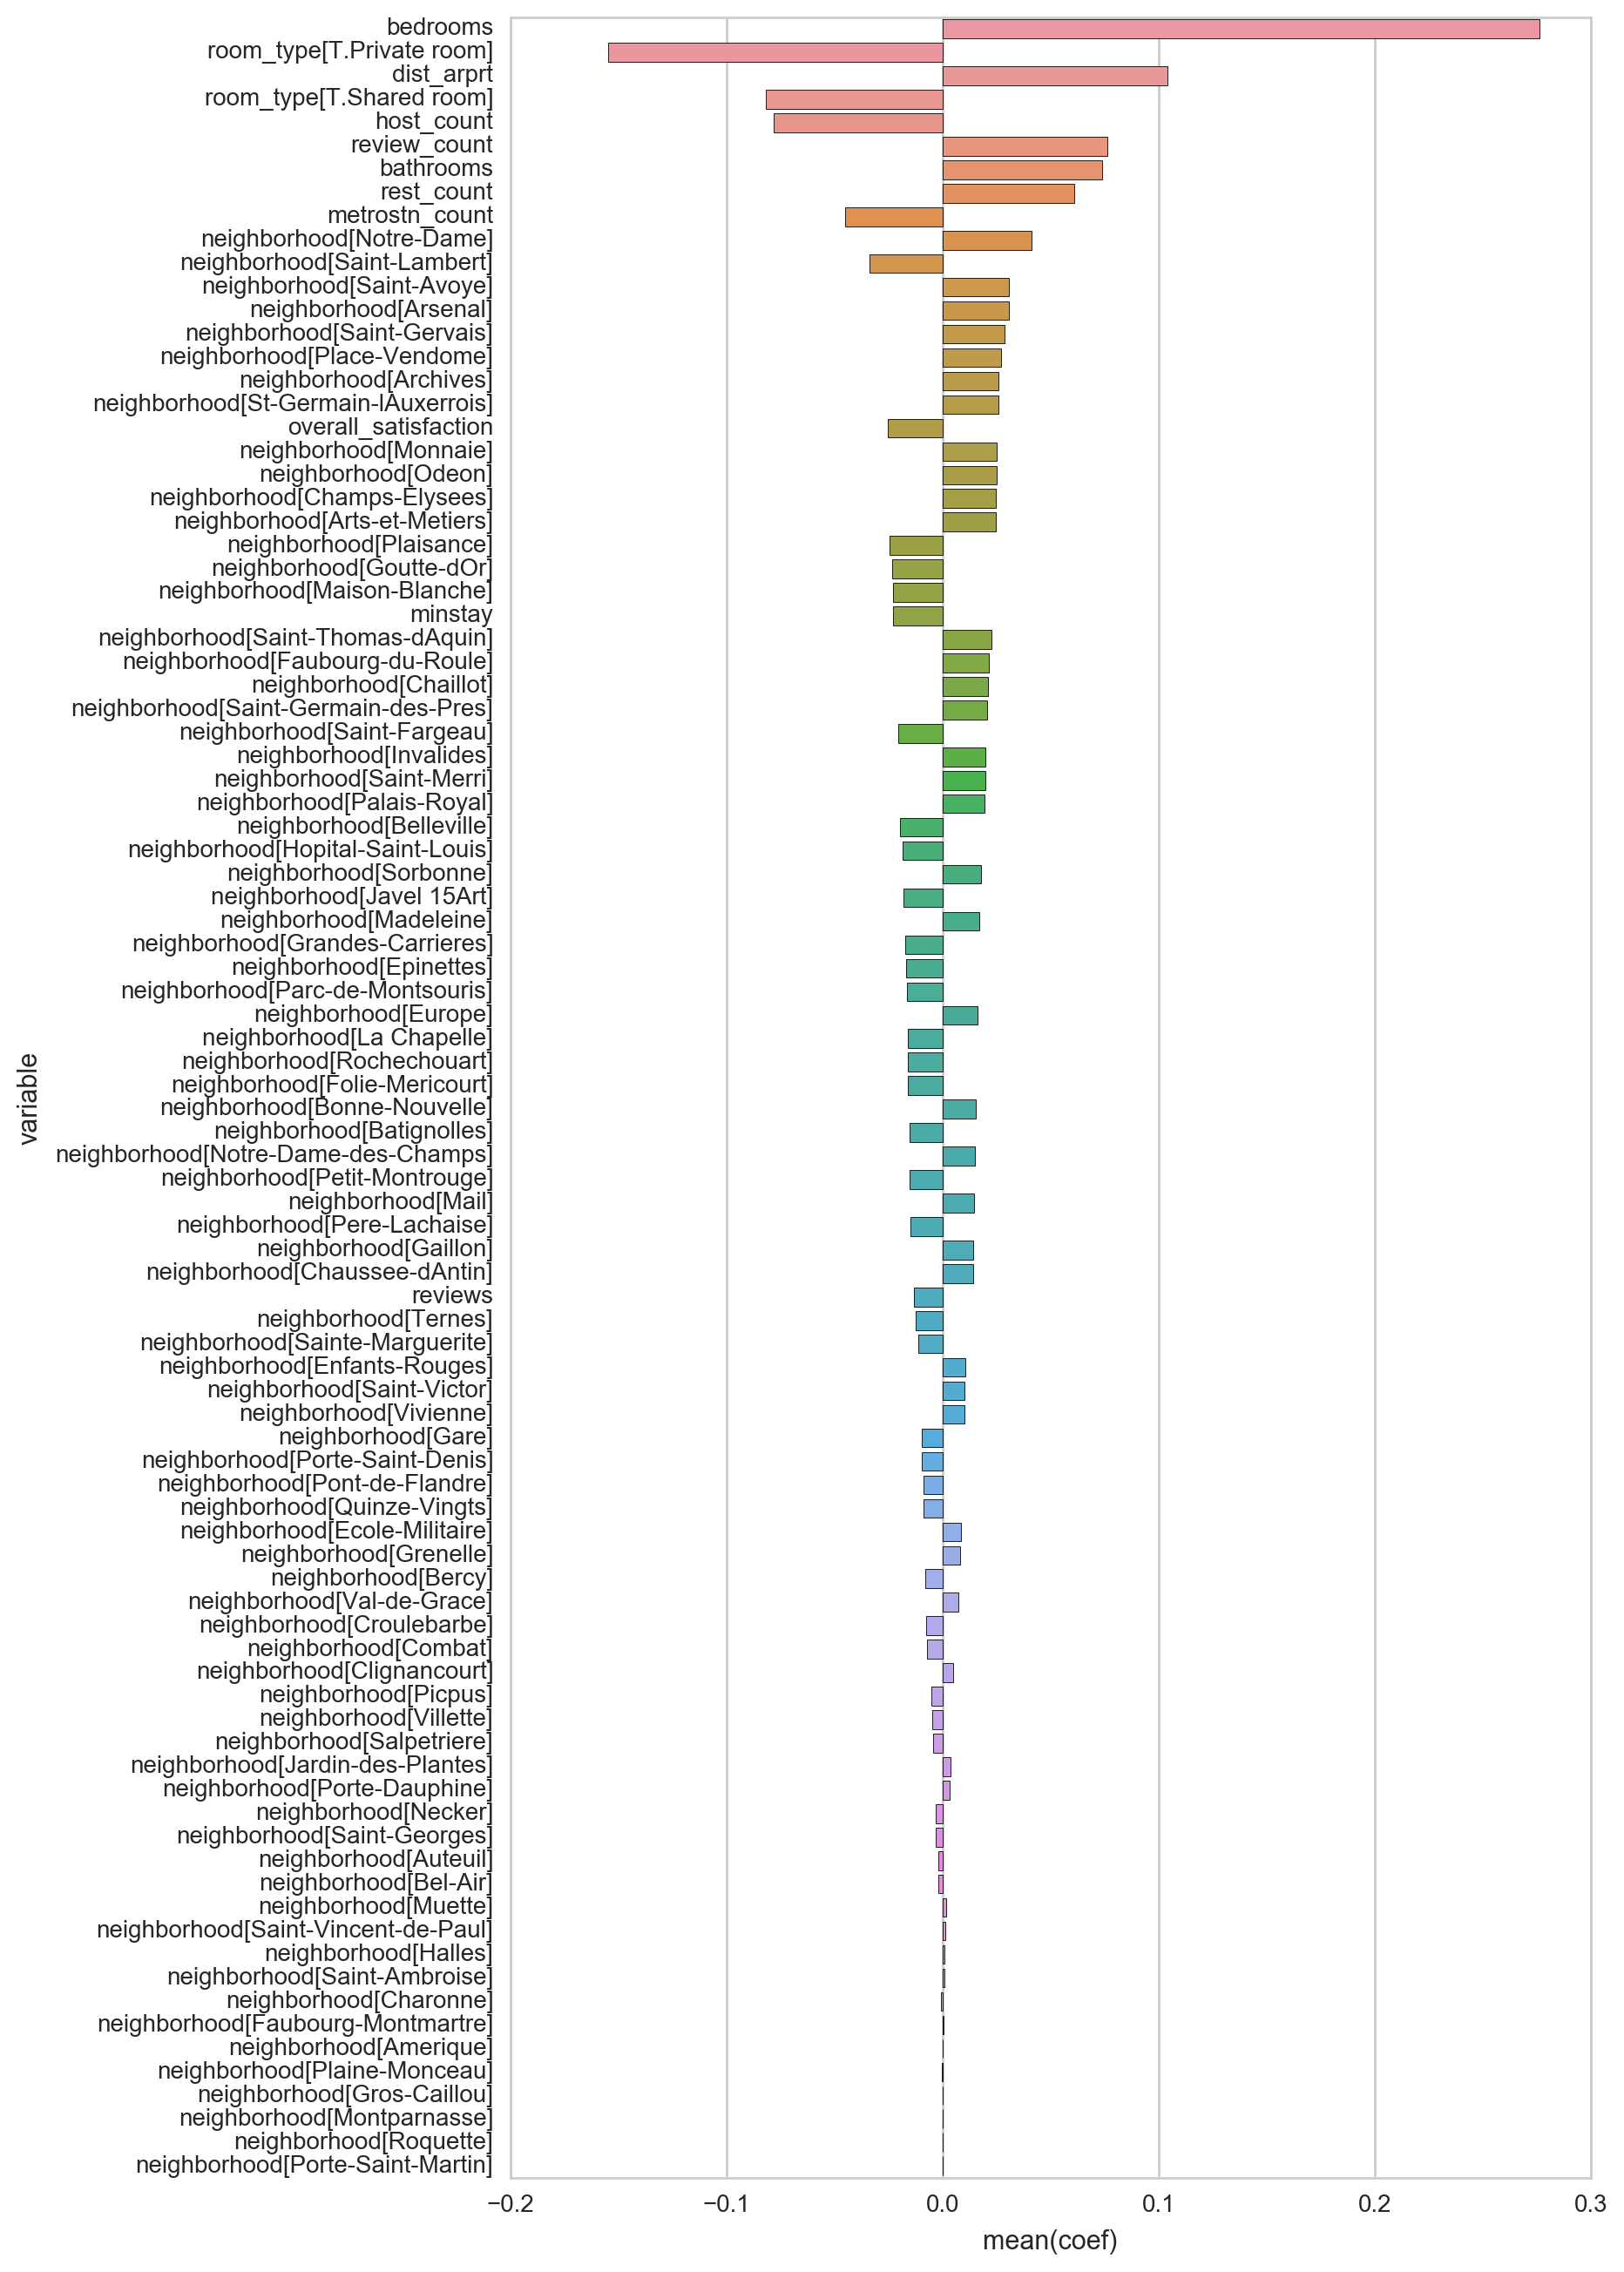

In [35]:
fig, ax = plt.subplots(figsize=(8,16))

sns.barplot(y = lasso_coef.variable, x = lasso_coef.coef, data=lasso_coef)


In [36]:
lasso_coef = lasso_coef.reset_index(drop=True)

In [37]:
lasso_coef

,abscoef,coef,variable
0,0.276207,0.276207,bedrooms
1,0.154673,-0.154673,room_type[T.Private room]
2,0.104337,0.104337,dist_arprt
3,0.081620,-0.081620,room_type[T.Shared room]
4,0.077906,-0.077906,host_count
5,0.076517,0.076517,review_count
6,0.073942,0.073942,bathrooms
7,0.060877,0.060877,rest_count
8,0.045063,-0.045063,metrostn_count
9,0.041370,0.041370,neighborhood[Notre-Dame]


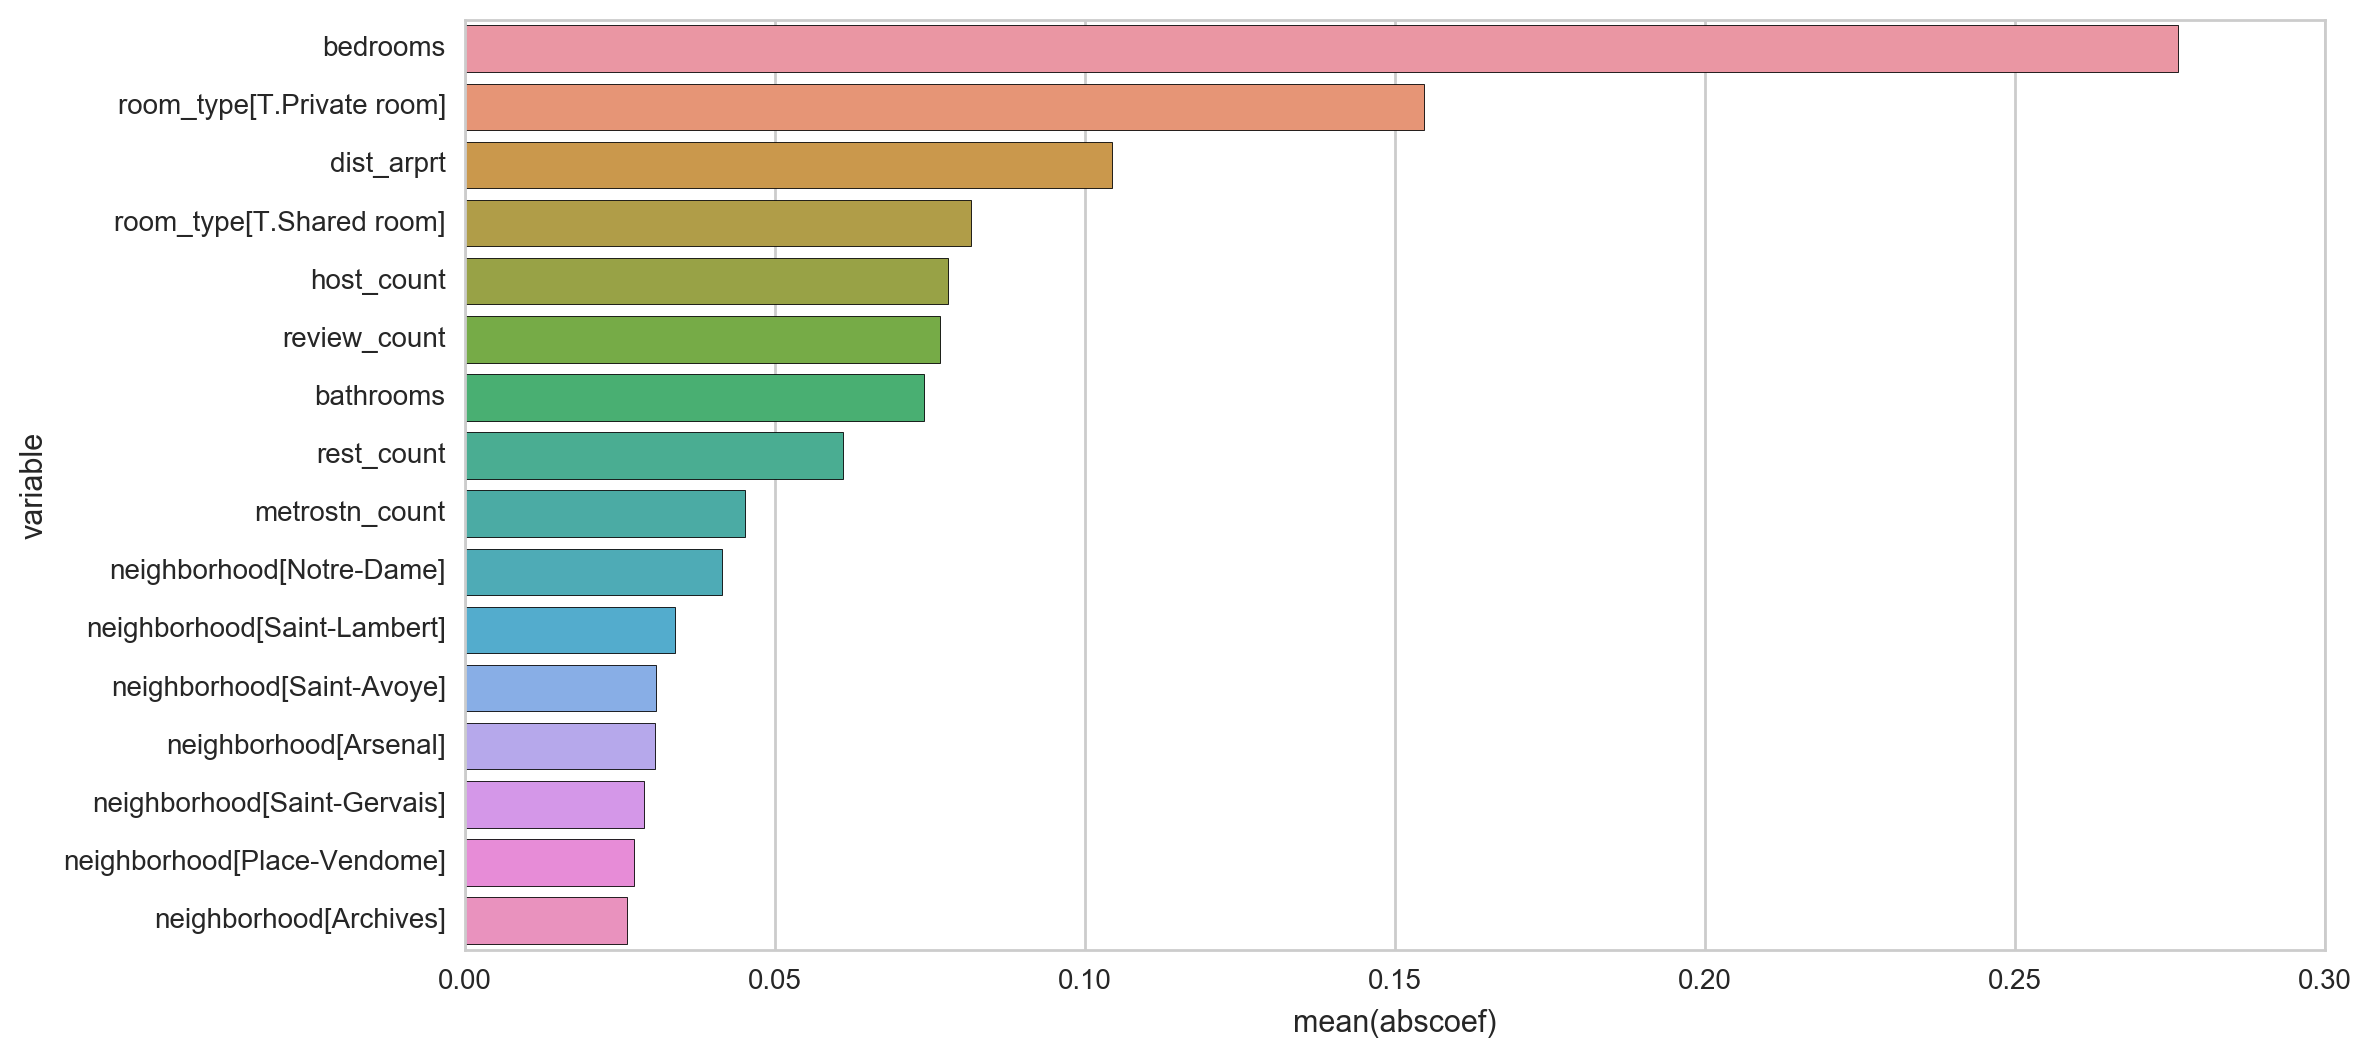

In [38]:
fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(y = lasso_coef.loc[0:15,:].variable, x = lasso_coef.loc[0:15,:].abscoef, data=lasso_coef.loc[0:15,:]
           )


In [39]:
#  rome = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Rome_dfm.csv',
                         
#                     encoding='utf8')

In [40]:
# def pred_target(df):
#     df.drop('Unnamed: 0', axis=1, inplace=True)
#     X = df[[x for x in df.columns if x not in ['bhk','price','neighborhood']]]
#     y = df.price.values
#     target = np.log(y)
#     formula = "target ~ "+' + '.join(X)+' -1'
#     y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
#     y = y.values.ravel()
#     return X, y
    

In [41]:
# X_rome, y_rome = pred_target(rome)

In [42]:
# Xn_rome = StandardScaler().fit_transform(X_rome)

In [43]:
# y_pred_lasso_rome = lasso.fit(Xn_train, y_train).predict(Xn_rome)
# r2_score_lasso_rome = metrics.r2_score(y_rome, y_pred_lasso_rome)
# print(lasso)
# print("r^2 on test data : %f" % r2_score_lasso_rome)


In [44]:
# price ~ neighborhood ---> model1
# take residuals out of model1 (price errors)
# residuals ~ features same across cities

In [46]:
# plt.plot(enet.coef_, color='lightgreen', linewidth=2,
#          label='Elastic net coefficients')
# plt.plot(lassocv.coef_, color='gold', linewidth=2,
#          label='Lasso coefficients')
# #plt.plot(linmod.coef_, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()

In [ ]:
# plt.plot(residuals, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()

sns.distplot(residuals, bins=50, kde=False)

In [ ]:
tmp = X_train.reset_index(drop=True)
tmp = tmp.loc[np.abs(residuals) >= 2.5]
tmp

In [ ]:
#tmp.ix[7670,:]